# Thomas Partey Statistical Profile

In [59]:
# Goals of this project

# Data Cleaning Part
    #1. Create and clean a database of the CDM's from the top 5 Leagues.
    #2. Database should include the defensive, passing, and misc stats
    #3. Also obtain the previous years match by match data of Thomas Partey
    #4. Final data should be as follows:
        #a. cdm_database.csv
        #b. thomas_partey.csv

# Things to plot/find/visualize
    #1. Scatter Plots:
        #a. Passing sum_val vs Defensive sum_val
        #b. Pure Passing Scatter( Accuracy vs Location of Passes)
        #c. Pure Defensive Scatter
        
    #2. Bar Plots:
        #a. TP vs Top 10 Tacklers,
        #b. TP vs Top 10 Interceptors,
        #c. TP vs Top 10 Dribbled Past,
        #d. TP vs Top 10 Ground Duels Won
        #e. TP vs Top 10 Aerial Duels Won
        #f. Year by Year Improvement of Partey (Defensive + Passing Stats)
        
    #3. Line Plots:
        #a. Consistency Evaluation (Alternate)
        
    #4. Violing Plots:
        #a. Consistency Evaluatio

In [404]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing
from unidecode import unidecode

%matplotlib notebook

## Data Cleaning

In [61]:
#Defining a few variables

#Folders
DEF_STATS = 'def_stats'
PASS_STATS = 'pass_stats'
MISC_STATS = 'misc_stats'

#Leagues
LIGUE1 = 'france'
BUNDESLIGA = 'germany'
EPL = 'england'
LALIGA = 'spain'
SERIEA = 'italy'

#CDM Database
CDM_DB = 'cdm_database'

COLUMNS = [
    
    #Def stats
    'Goals',
    'Dribbled Past',
    'Tackles',
    'Errors Leading to Shots',
    'Interceptions',
    'Blocked Shots',
    
    #Pass stats
    'Accurate Pass %',
    'Accurate Passes in Own Half',
    'Accurate Passes in Opposition Half',
    'Accurate Passes in Final Third',
    'Key Passes',
    'Accurate Long Ball %',
    
    #Misc stats
    'Ground Duels %Won',
    'Aerial Duels %Won',
    'Minutes Played',
    'Was Fouled',
    'Dispossessed',
    'Matches Started',
    
]

In [218]:
#Obtaining statistics of all cdm's into one dataframe by defining functions

def get_stats(stat_name):
    #Simple method to list all files and return as dataframes
    
    stat_files = os.listdir(stat_name)
    return [pd.read_table(stat_name +'/' + file, encoding = "ISO-8859-1", header = None) for file in stat_files]

def create_dataframe(defensive, passing, misc):
    
    all_data = []
    for i in range(len(defensive)):
        
        #Find minimum length
        n = min(len(defensive[i]), len(passing[i]), len(misc[i]))
        
        def_df = defensive[i].iloc[:n].set_index([0, 1, 2])
        pas_df = passing[i].iloc[:n].set_index([0, 1, 2])
        mis_df = misc[i].iloc[:n].set_index([0, 1, 2])
        
        all_stats = pd.concat([def_df, pas_df, mis_df], axis = 'columns')
        all_stats.columns = COLUMNS
        all_data = all_data + [all_stats]
        
    all_data =  pd.concat(all_data)
    all_data = all_data.reset_index().drop([0, 1], axis = 'columns')
    all_data = all_data.rename({2:'Name'}, axis = 'columns')
    all_data = all_data.drop_duplicates(['Name'], keep = 'last')
    all_data = all_data.set_index(['Name'])
    return all_data

def fifa_df():
    
    STR_PERM = [
        'CM',
        'CDM',
    ]

    cols = [
        'Name',
        'Nationality',
        'Age',
        'Club'
    ]

    df = pd.read_table(CDM_DB +'.txt', encoding = "ISO-8859-1", header = None)
    df = df[df[4].str.contains('^CDM', na = False)]
    df = df.drop([2, 3, 4, 6], axis = 'columns')
    df.columns = cols
    df = df.drop_duplicates(['Name'], keep = 'last')
    return df

In [461]:
#Calling the defined functions

def_stats = get_stats(DEF_STATS)
pass_stats = get_stats(PASS_STATS)
misc_stats = get_stats(MISC_STATS)

all_data = create_dataframe(def_stats, pass_stats, misc_stats)
cdm_df = fifa_df()

#Combing our stats for midfielders + list of CDM's
cdm_stats = cdm_df.join(all_data, on = 'Name', how = 'inner')

#Converting names to unicode
conv_dict = {i:unidecode(i) for i in cdm_stats['Name'].values}
cdm_stats['Name'] = cdm_stats['Name'].replace(conv_dict)

#Getting ball recoveries
br = pd.read_csv('ball_recoveries.csv')
br = br[['Player Name', 'BR']]
br = br.set_index('Player Name')
cdm_stats = cdm_stats.join(br, on = 'Name', how = 'inner')

cdm_stats = cdm_stats.rename({'BR':'Ball Recoveries'}, axis = 1)


cdm_stats.to_csv(CDM_DB + '.csv', index = None)



#CDM database finalized

## Implementing Goals + Visualization

In [462]:
cdm_stats[cdm_stats['Name'] == 'Wilfred Ndidi']

,Name,Nationality,Age,Club,Goals,Dribbled Past,Tackles,Errors Leading to Shots,Interceptions,Blocked Shots,...,Accurate Passes in Final Third,Key Passes,Accurate Long Ball %,Ground Duels %Won,Aerial Duels %Won,Minutes Played,Was Fouled,Dispossessed,Matches Started,Ball Recoveries
684,Wilfred Ndidi,Nigeria,22.0,Leicester City,2.0,49.0,143.0,2.0,83.0,9.0,...,328.0,23.0,52.0,58.0,55.0,3298.0,22.0,36.0,37.0,324


In [470]:
cdm_stats = pd.read_csv(CDM_DB + '.csv', )

#Before implementing, initialize variable to simplify
    #1. Access to df
    #2. Conditions (Minutes Played etc)
    #3. Re-organzing columns into categories

#stats that help the cdm get and keep the ball
DEFENSIVE = [
    
    'Tackles',
    'Interceptions',
    'Ball Recoveries',
    'Blocked Shots',
    'Ground Duels %Won',
    'Aerial Duels %Won',
    'Was Fouled',
    'Dribbled Past', #Negative Correlation
    'Errors Leading to Shots', #Negative Correlation to defense
    'Dispossessed' #Negative Correlation to defense

]

#stats that indicate the passing abilities
PASSING = [
    
    'Accurate Pass %',
    'Accurate Passes in Own Half', #No effect on passing ability
    'Accurate Passes in Opposition Half', #No effect on passing ability
    'Accurate Passes in Final Third', #No affect on passing ability
    'Accurate Long Ball %', #No affect on passing ability/Not a required trait
    'Key Passes'
    
]

#basic stats about player
META = [
    
    'Name',
    'Nationality',
    'Age',
    'Club',
    'Minutes Played',
    'Matches Started',
    'Goals'
    
]

In [471]:
#Before procceeding to visualize, certain constraints (minutes played)
constraint = cdm_stats[META[-3]] > 900

cdm_stats = cdm_stats[constraint]


In [472]:
DEFENSIVE[0:-4]

['Tackles',
 'Interceptions',
 'Ball Recoveries',
 'Blocked Shots',
 'Ground Duels %Won',
 'Aerial Duels %Won']

In [473]:
cdm_stats.columns

Index(['Name', 'Nationality', 'Age', 'Club', 'Goals', 'Dribbled Past',
       'Tackles', 'Errors Leading to Shots', 'Interceptions', 'Blocked Shots',
       'Accurate Pass %', 'Accurate Passes in Own Half',
       'Accurate Passes in Opposition Half', 'Accurate Passes in Final Third',
       'Key Passes', 'Accurate Long Ball %', 'Ground Duels %Won',
       'Aerial Duels %Won', 'Minutes Played', 'Was Fouled', 'Dispossessed',
       'Matches Started', 'Ball Recoveries'],
      dtype='object')

### Defensive Scatter

<IPython.core.display.Javascript object>


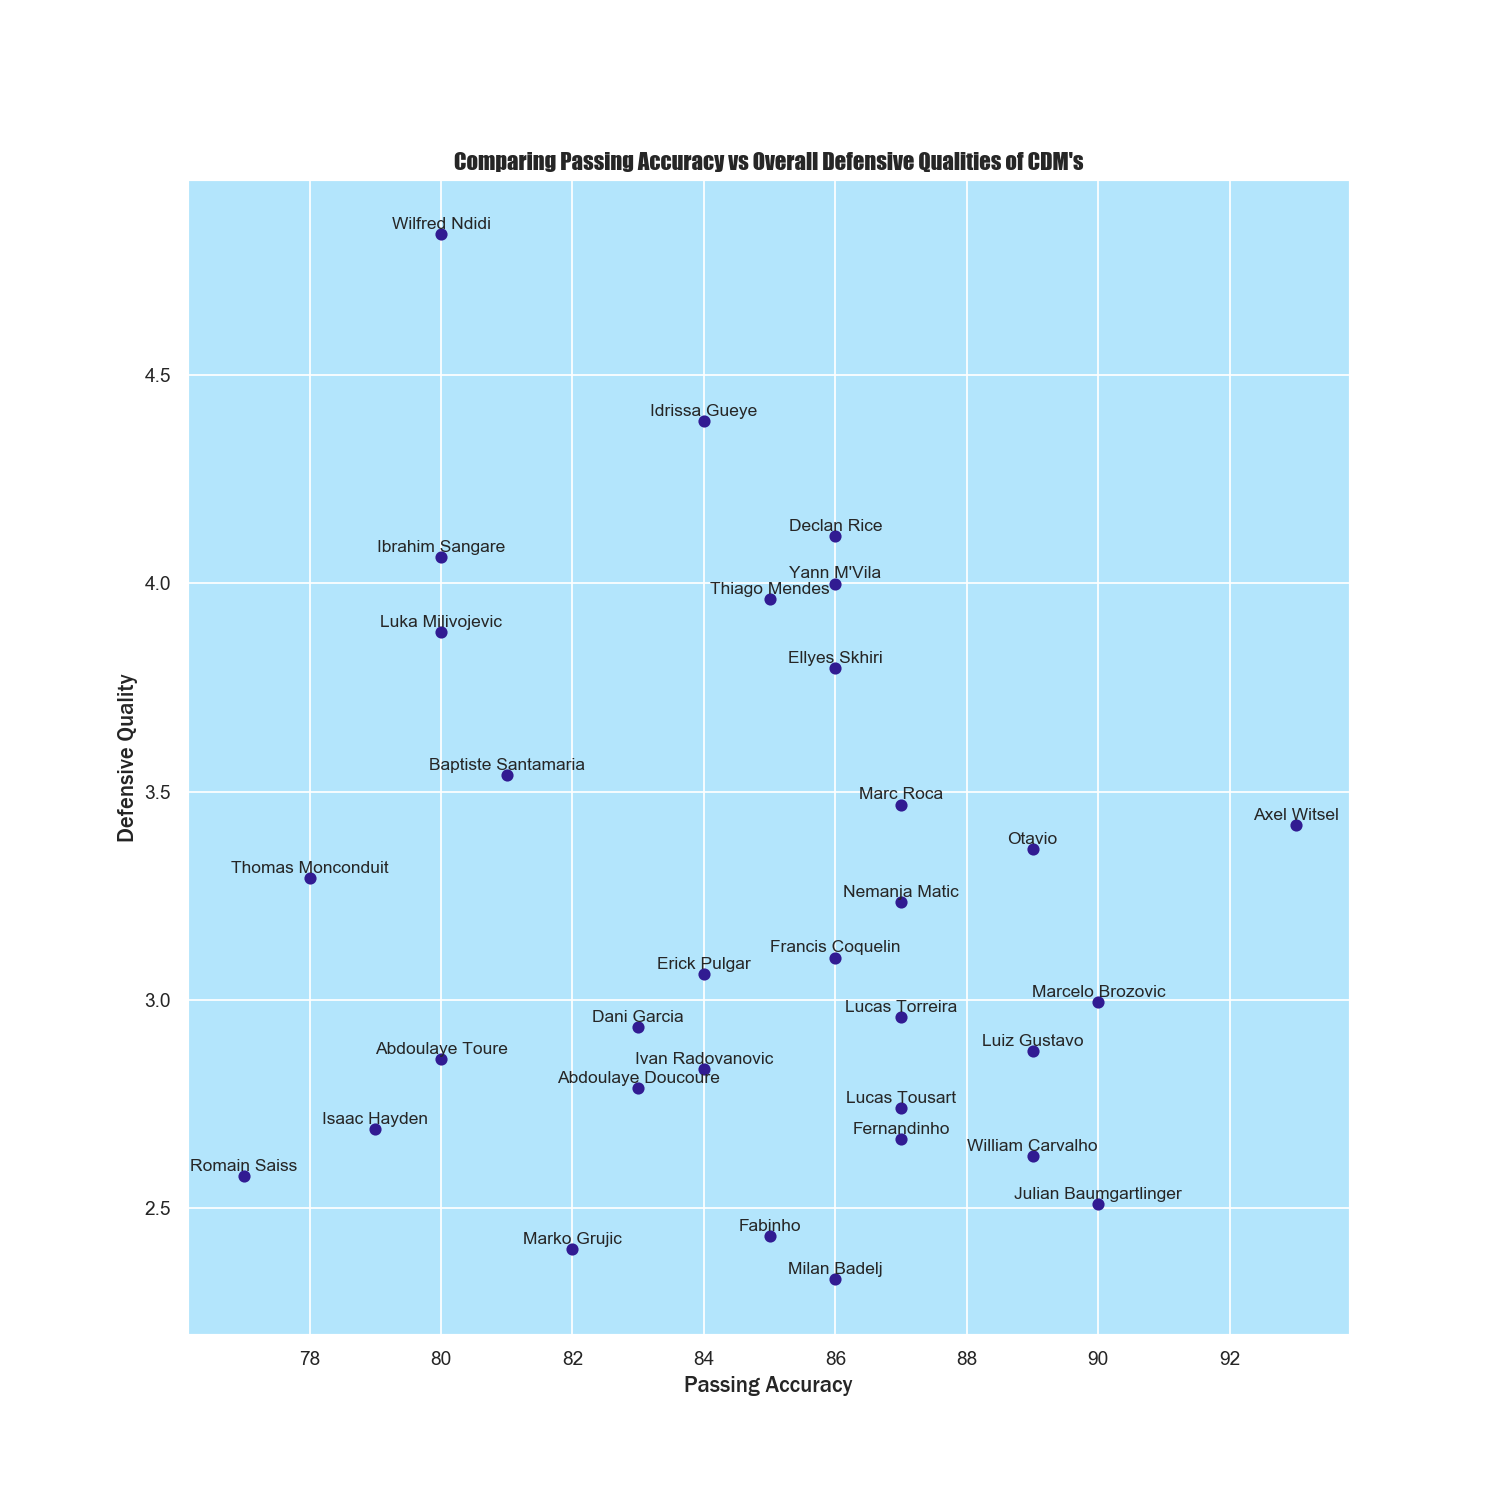

In [474]:
#Manage the negatively correlated variables

fig = plt.figure()

df = cdm_stats.copy()
df[DEFENSIVE[-1]] = - df[DEFENSIVE[-1]]
df[DEFENSIVE[-2]] = - df[DEFENSIVE[-2]]
df[DEFENSIVE[-3]] = - df[DEFENSIVE[-3]]

#Need to scale values to make it appropriate for comparisons

def sum_val(df, columns):
    df['sumVal'] = df[columns].sum(axis = 1)
    return df

mx = preprocessing.MinMaxScaler()
df[DEFENSIVE] = mx.fit_transform(df[DEFENSIVE])
df = sum_val(df, DEFENSIVE[0:-4]).sort_values('sumVal', ascending = False)

df = df.iloc[:50]

#sns.scatterplot(x = "Accurate Pass %", y = "sumVal", data = df)










#df = df.sort_values(by = 'Accurate Pass %', ascending=True)
n = df['Name'].values

ixs = df.index
x = df['Accurate Pass %'].values
y = df['sumVal'].values

#sz = vdf['P%'].values
#sz = adf.iloc[ixs]['A'].values + 8

hfont = {'fontname':'Helvetica'}
config = {
    'ha': 'center', 
    'va': 'center'
}

for i, txt in enumerate(n):
    
    if i != 0:
        dis = y[i-1] - y[i]
        if dis > 0.02:
            plt.scatter(x[i], y[i], c = '#311b92')
            plt.text(x[i], y[i]+ 0.023, txt, config,  fontsize = 10, rotation = 0)
            
    else:
        plt.scatter(x[i], y[i], c = '#311b92')
        plt.text(x[i], y[i]+ 0.023, txt, config,  fontsize = 10, rotation = 0)
        





fig = plt.gcf()
ax = plt.gca()

#ax.set_xticklabels(ax.get_xticklabels(), family = "Courier New", fontsize = 11)
#ax.set_yticklabels(ax.get_yticklabels(), family = "Courier New", fontsize = 11)

ax.set_xlabel("Passing Accuracy", family = "Franklin Gothic Medium", fontsize = 13)
ax.set_ylabel("Defensive Quality", rotation = 90, family = "Franklin Gothic Medium", fontsize = 13)

ax.set_title("Comparing Passing Accuracy vs Overall Defensive Qualities of CDM's", family = "Impact", fontsize = 13)

fig.savefig("pass_def.jpg", dpi = 500)

### Bar Plots

In [468]:
#Methods

def per90(df, string):
    df[string+'90'] = df[string] / df['Minutes Played'] * 90
    return df

def plot_topn_comparison(statistic, player, data, n, per_90):

    fig = plt.figure()
    df = data.copy()
    if per_90:
        df = per90(df, statistic)
        statistic = statistic + '90'
    df = df.sort_values(statistic, ascending = False)


    player_index = df[df['Name'] == player].index
    idxs = df.iloc[:n].index
    
    #Check if player already in Top 10
    not_in_top_10 = all(np.isin(idxs, player_index) == False)
    
    if not_in_top_10:
        data = df.loc[idxs.append(player_index)]
    else:
        data = df.loc[idxs]
        
    
    a = df[statistic].iloc[:n]
    b = df[df['Name'] == player][statistic]
    
    val = min(np.append(a, b))
    
    #Plot Settings
    
    sns.set(rc={'figure.figsize':(12, 12)})
    sns.set_style("darkgrid", {"axes.facecolor": "#b3e5fc"})

    #if not in top 10
    if not_in_top_10:
        flatui = ["#263238"] * (n)
        flatui = flatui + ["#bf360c"]
        pal=sns.color_palette(flatui)
    else:
        i = idxs.values.tolist().index(player_index.values)
        if i == 0:
                flatui = ["#bf360c"]
                flatui = flatui + ["#263238"] * (n-1)
                pal=sns.color_palette(flatui)
        else:
            flatui = ["#263238"] * (i)
            flatui = flatui + ["#bf360c"]
            flatui = flatui + ["#263238"] * (n-i-1)
            pal=sns.color_palette(flatui)
    


    sns.barplot(x = 'Name', y = statistic, data = data , palette=pal)
    
    ax = plt.gca()
    
    lims = ax.get_ylim()
    ax.set_ylim(val - 5*val/100, lims[1])
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, family = "Courier New")
    
    ax.set_xlabel("Player", family = "Franklin Gothic Medium", fontsize = 13)
    ax.set_ylabel(statistic, rotation = 90, family = "Franklin Gothic Medium", fontsize = 13,)
    
    title = "Comparing {} of Top {} defensive midfielders vs {}".format(statistic, n, player)
    ax.set_title(title, family ="Franklin Gothic Medium", fontsize = 13)
    
    plt.tight_layout()
    
    fig = plt.gcf()
    if not os.path.exists(player):
        os.makedirs(player)
    fig.savefig(player + '/' + statistic +' ' + player + '.jpg', dpi = 500)
    
    return ax

In [469]:
DEFENSIVE[0:-4]

['Tackles',
 'Interceptions',
 'Blocked Shots',
 'Ground Duels %Won',
 'Aerial Duels %Won',
 'Ball Recoveries']

<IPython.core.display.Javascript object>


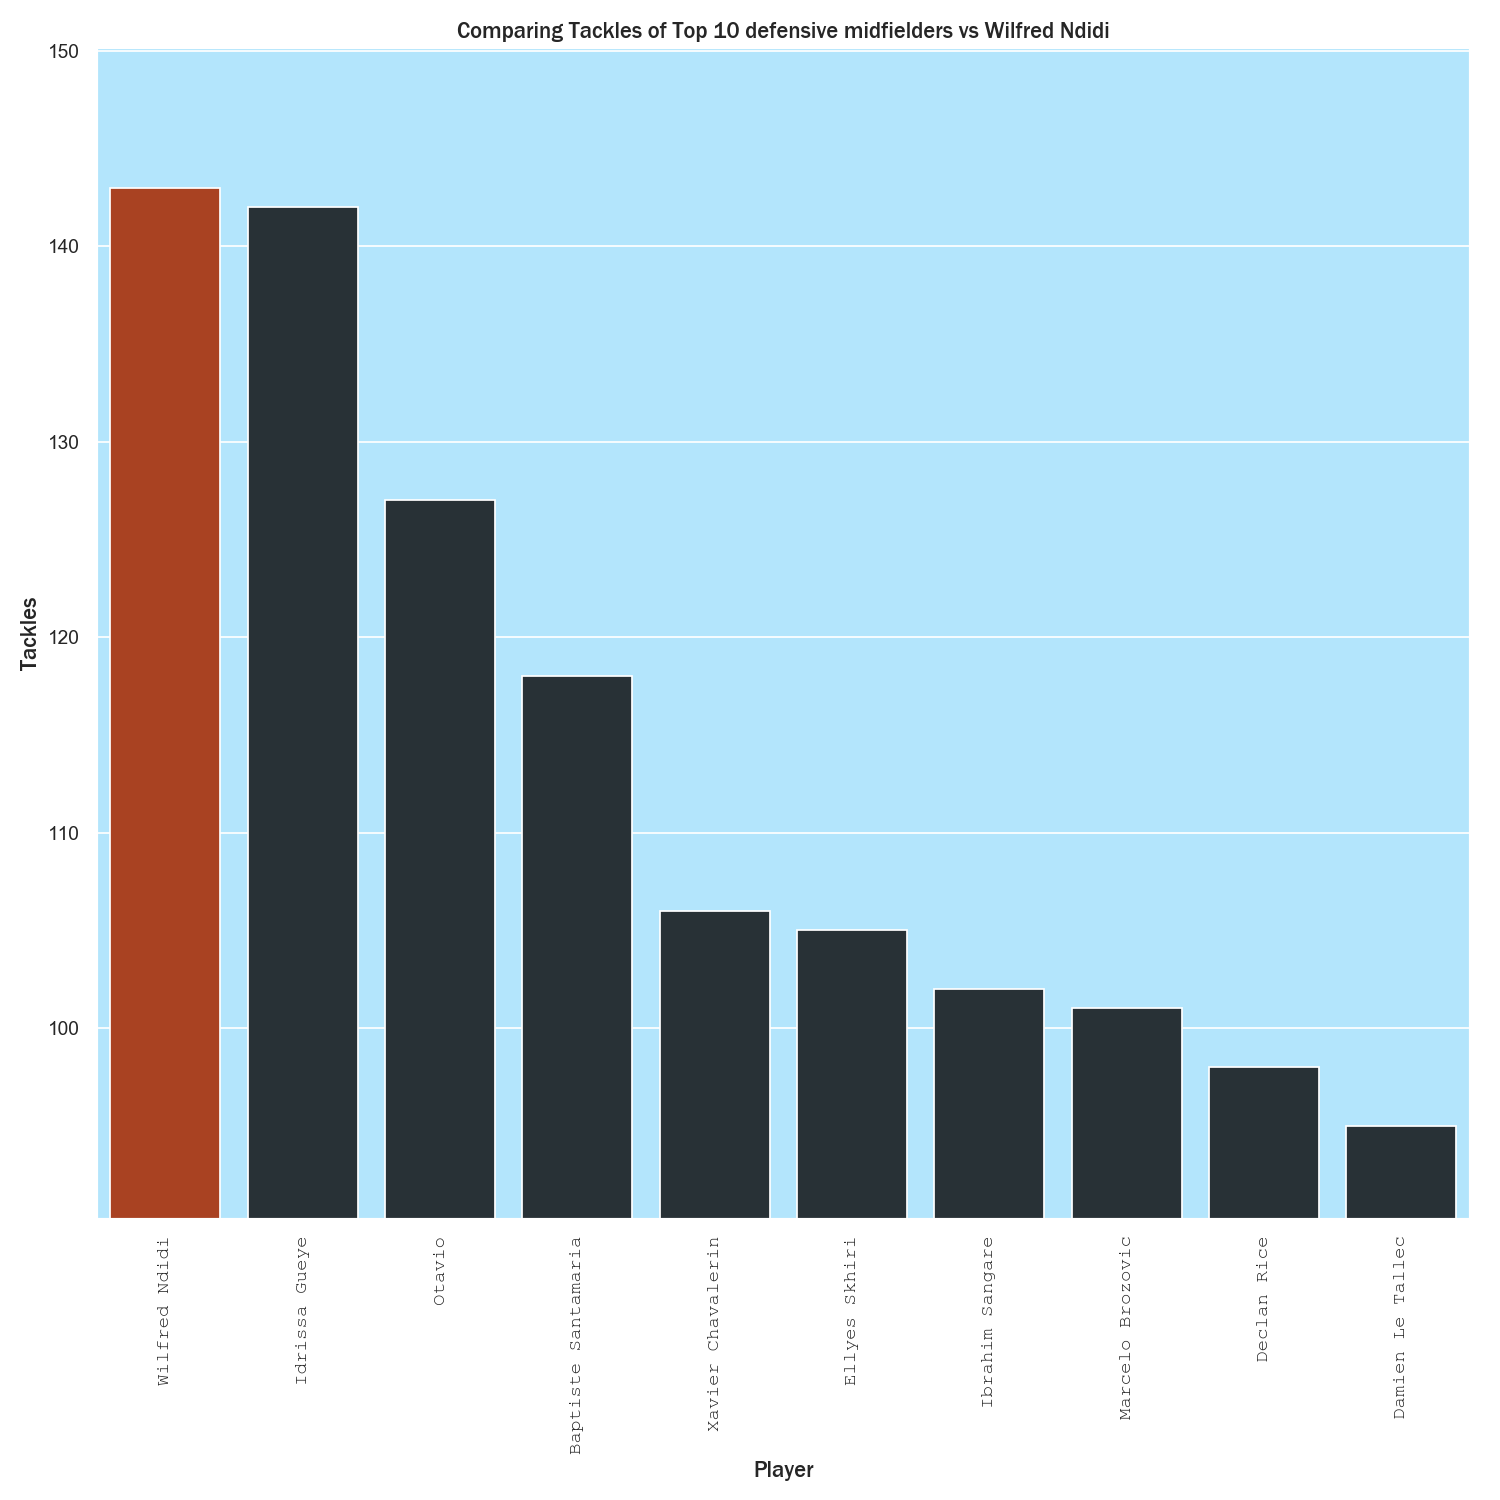

<IPython.core.display.Javascript object>


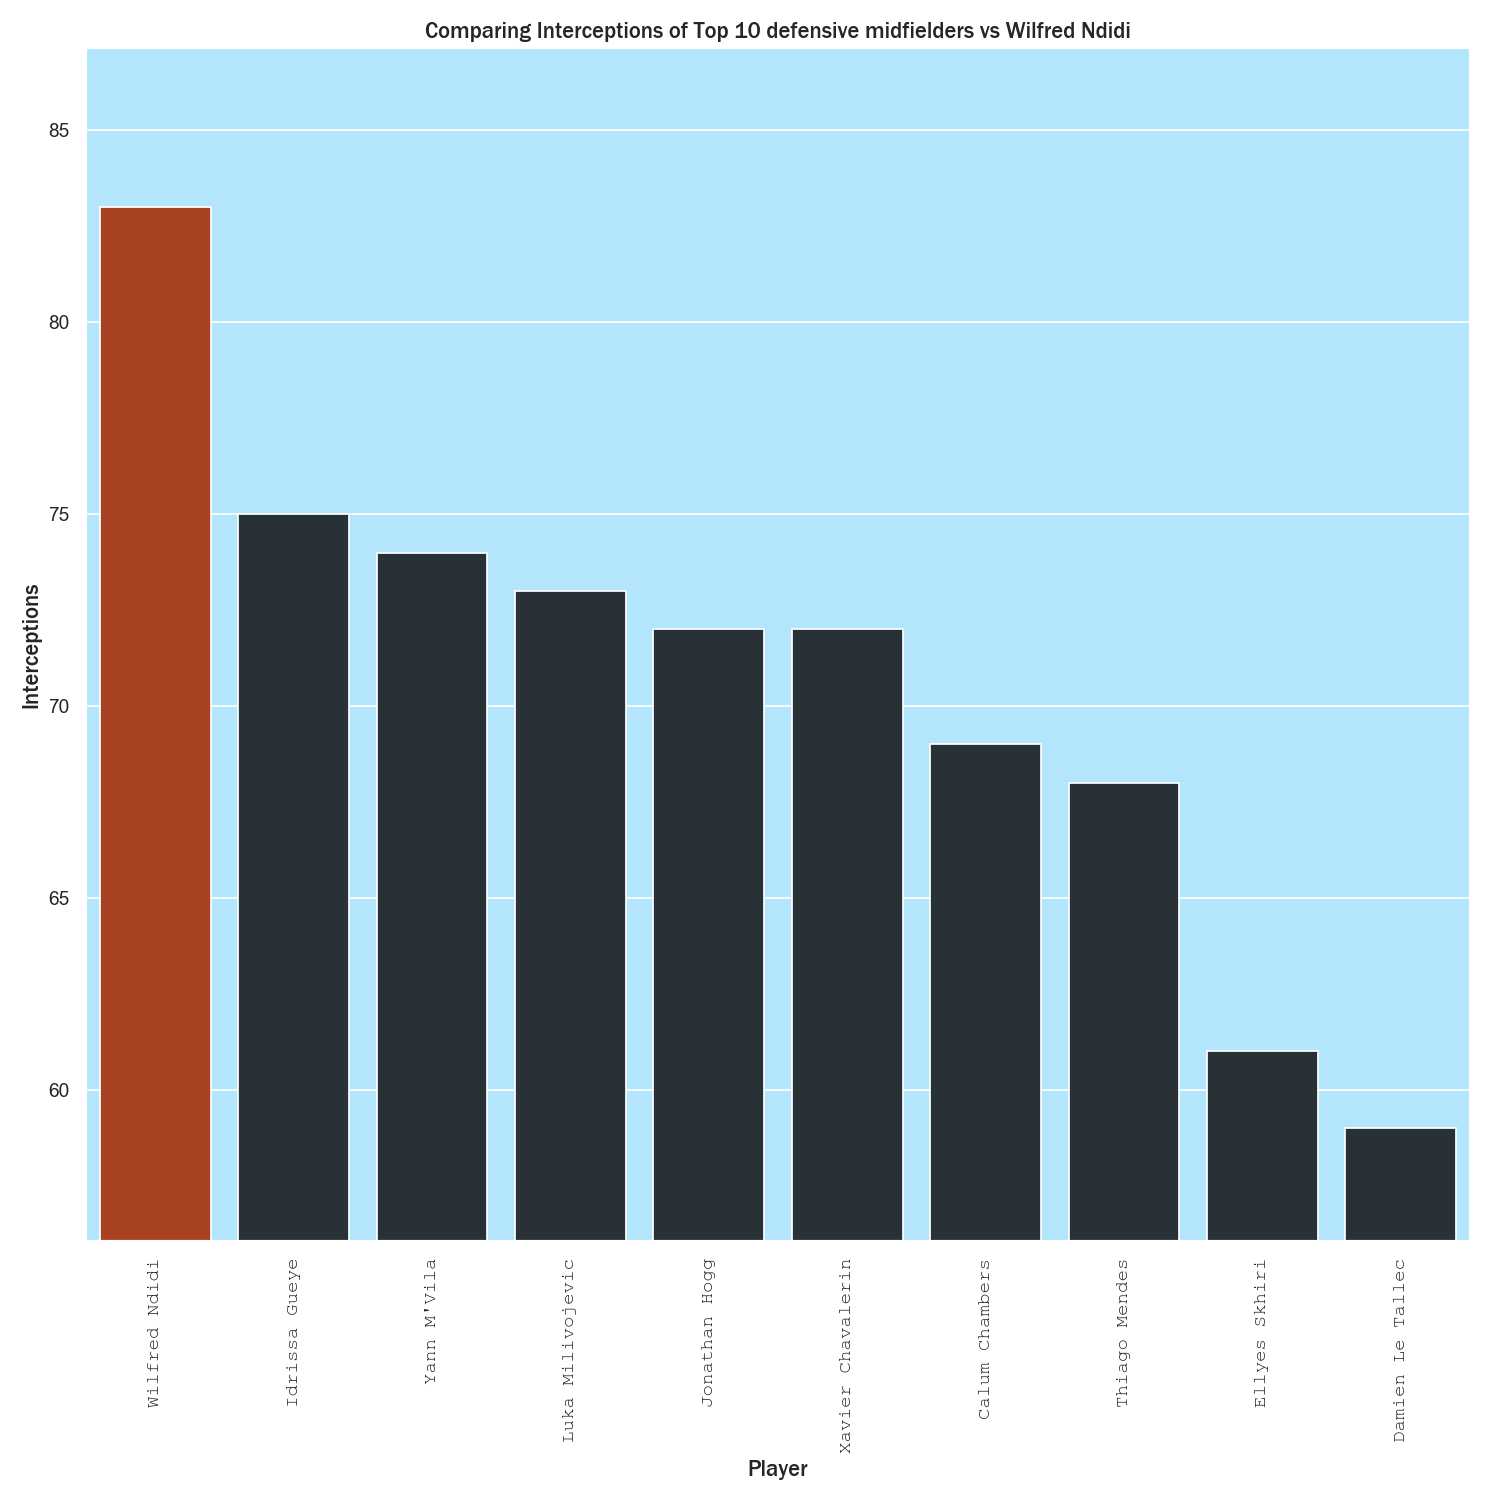

<IPython.core.display.Javascript object>


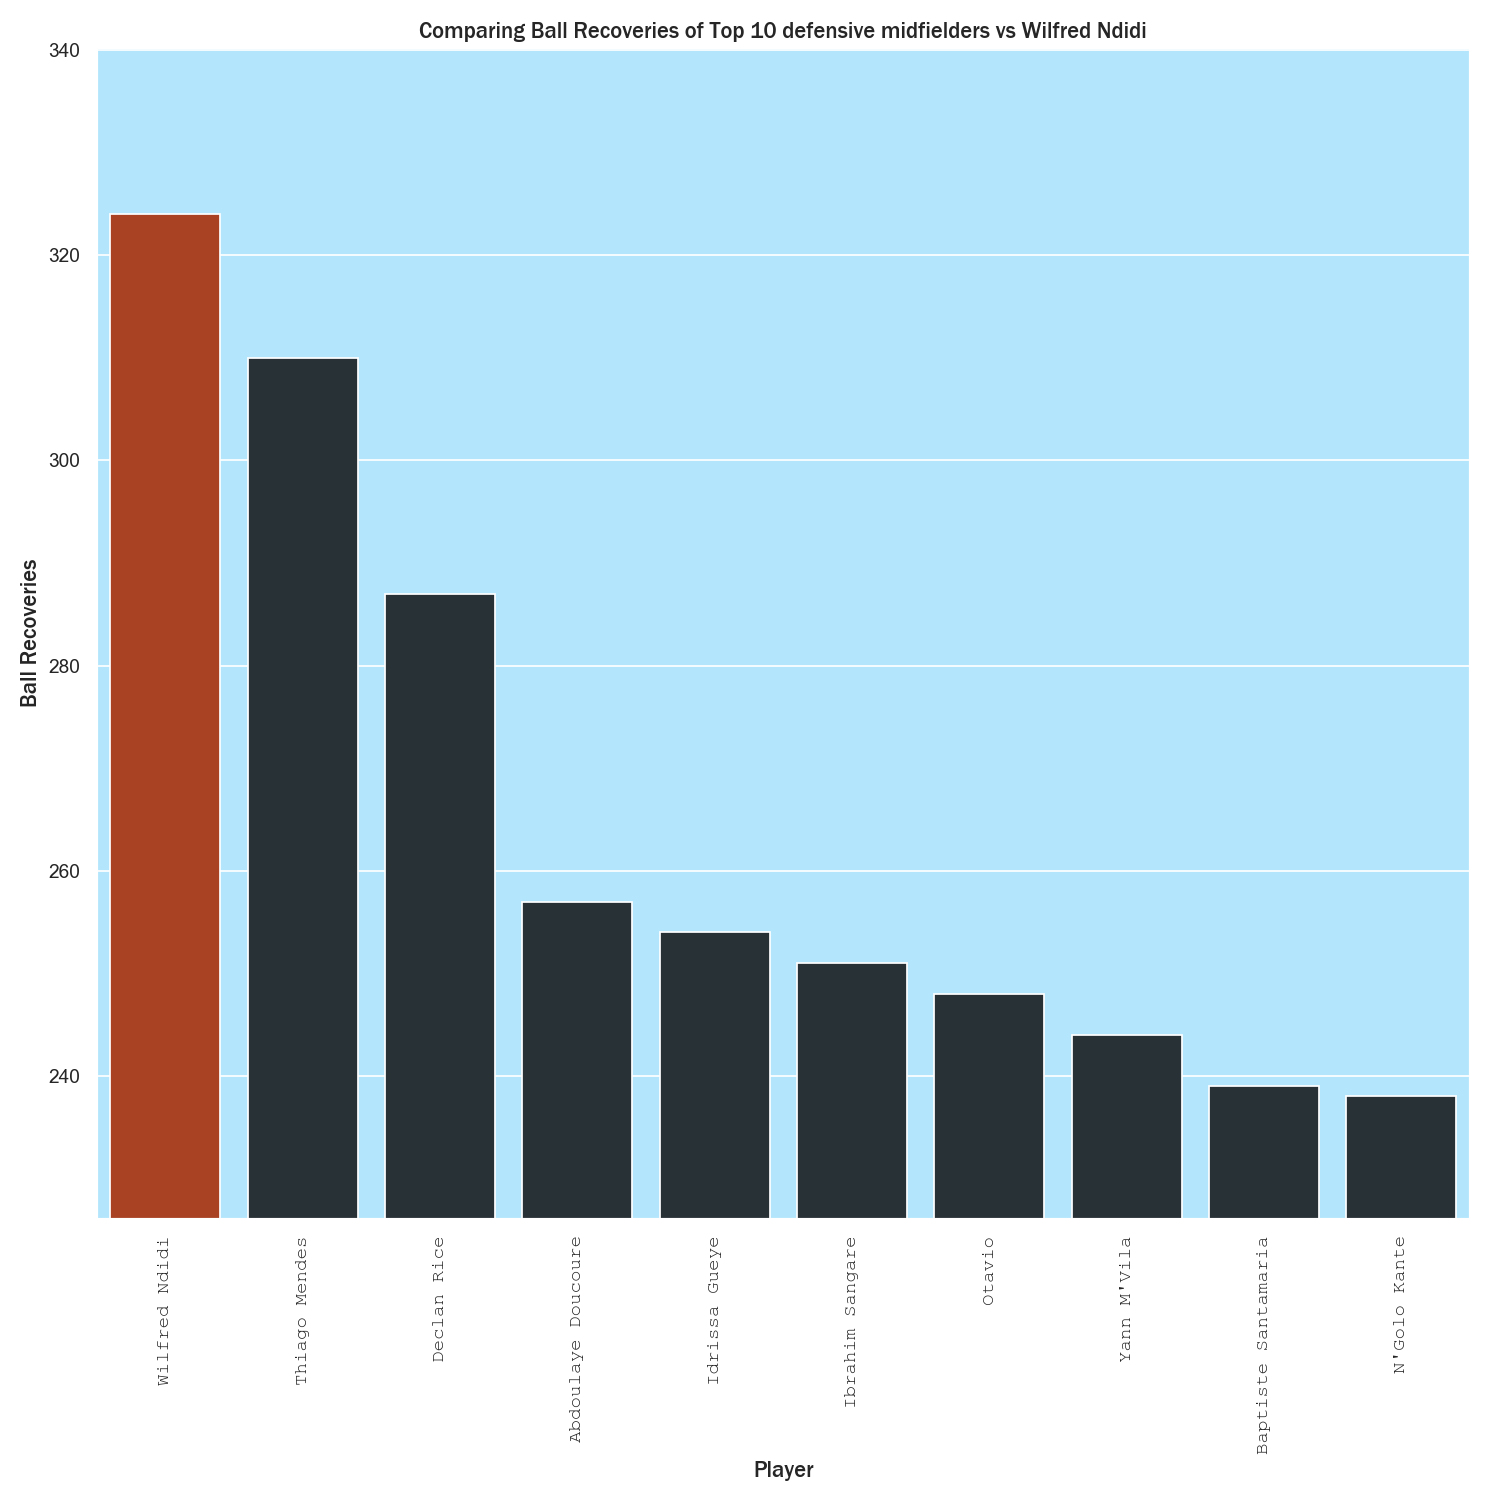

<IPython.core.display.Javascript object>


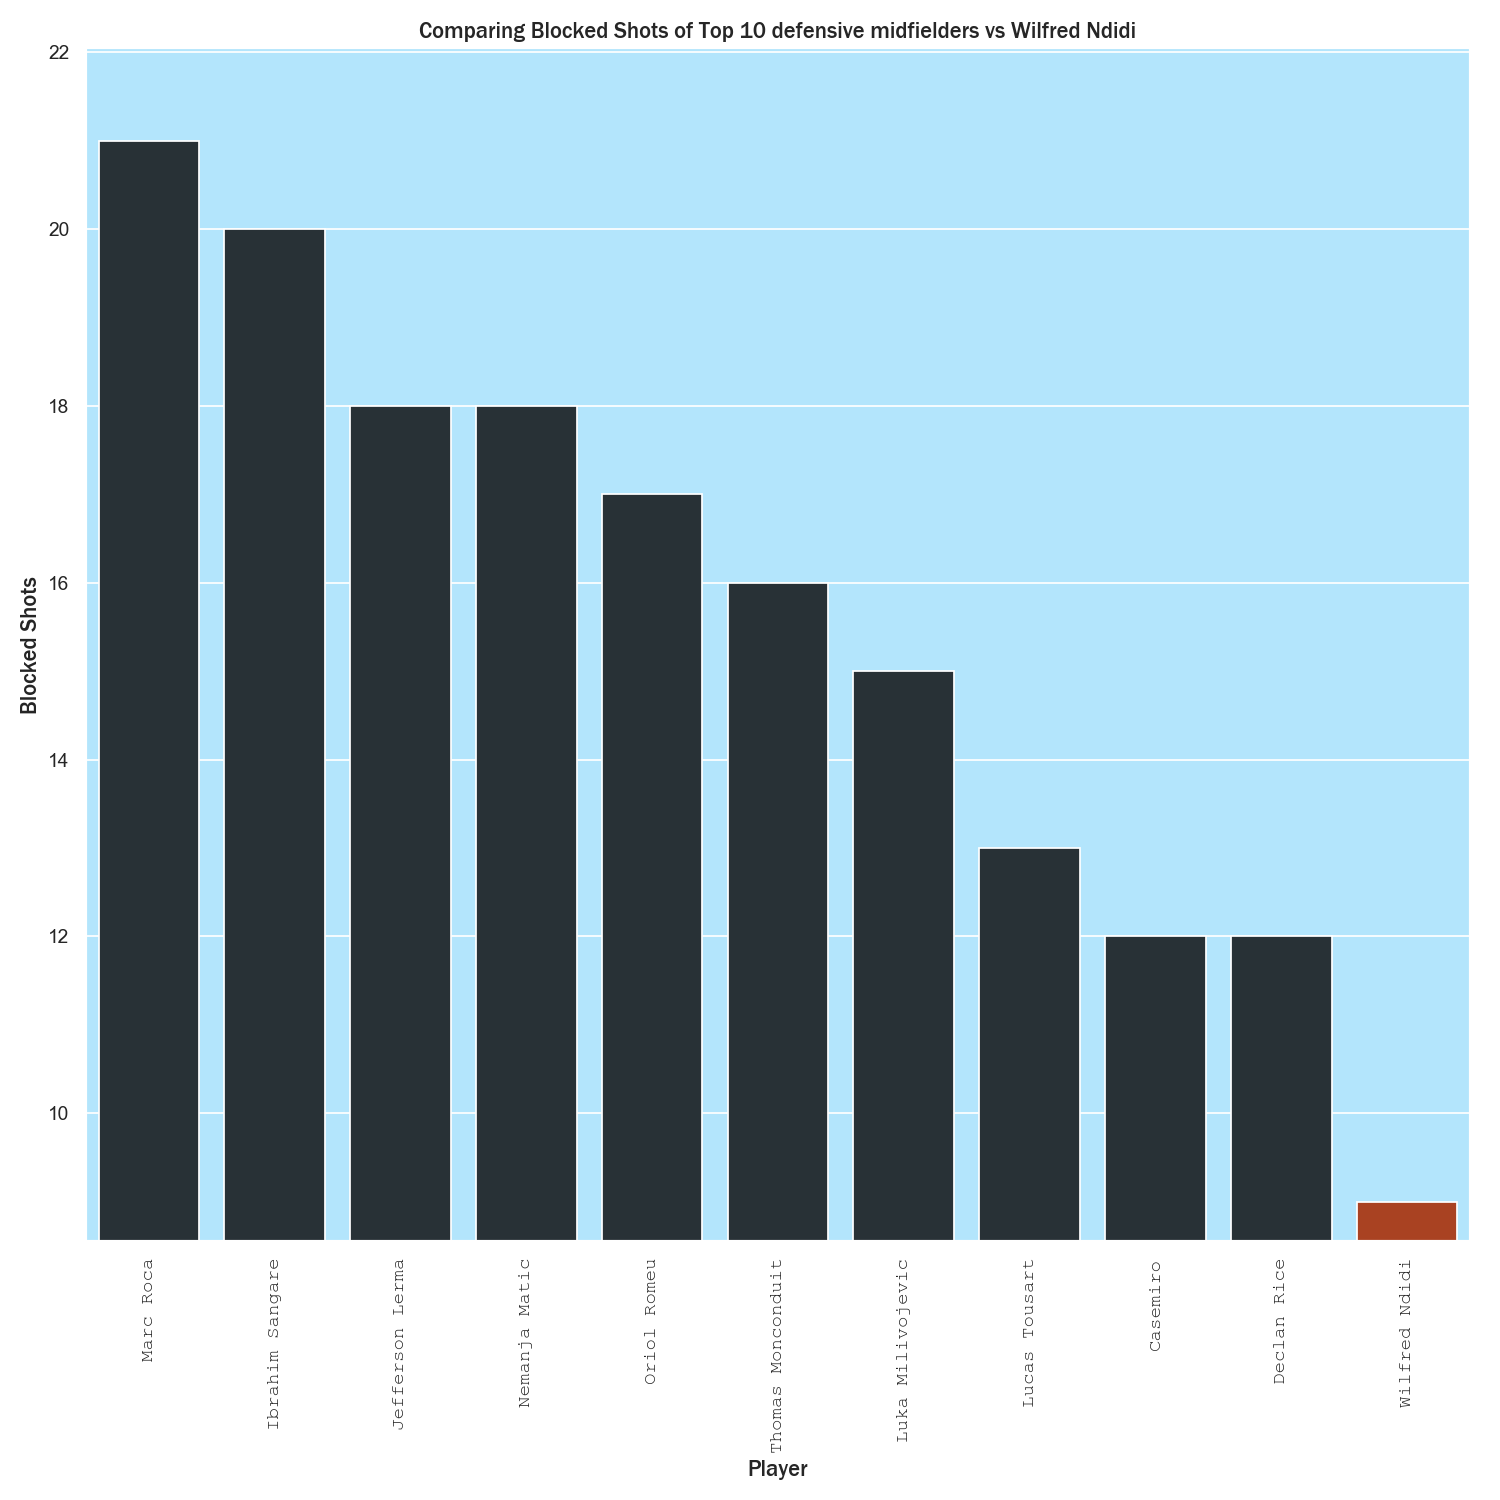

<IPython.core.display.Javascript object>


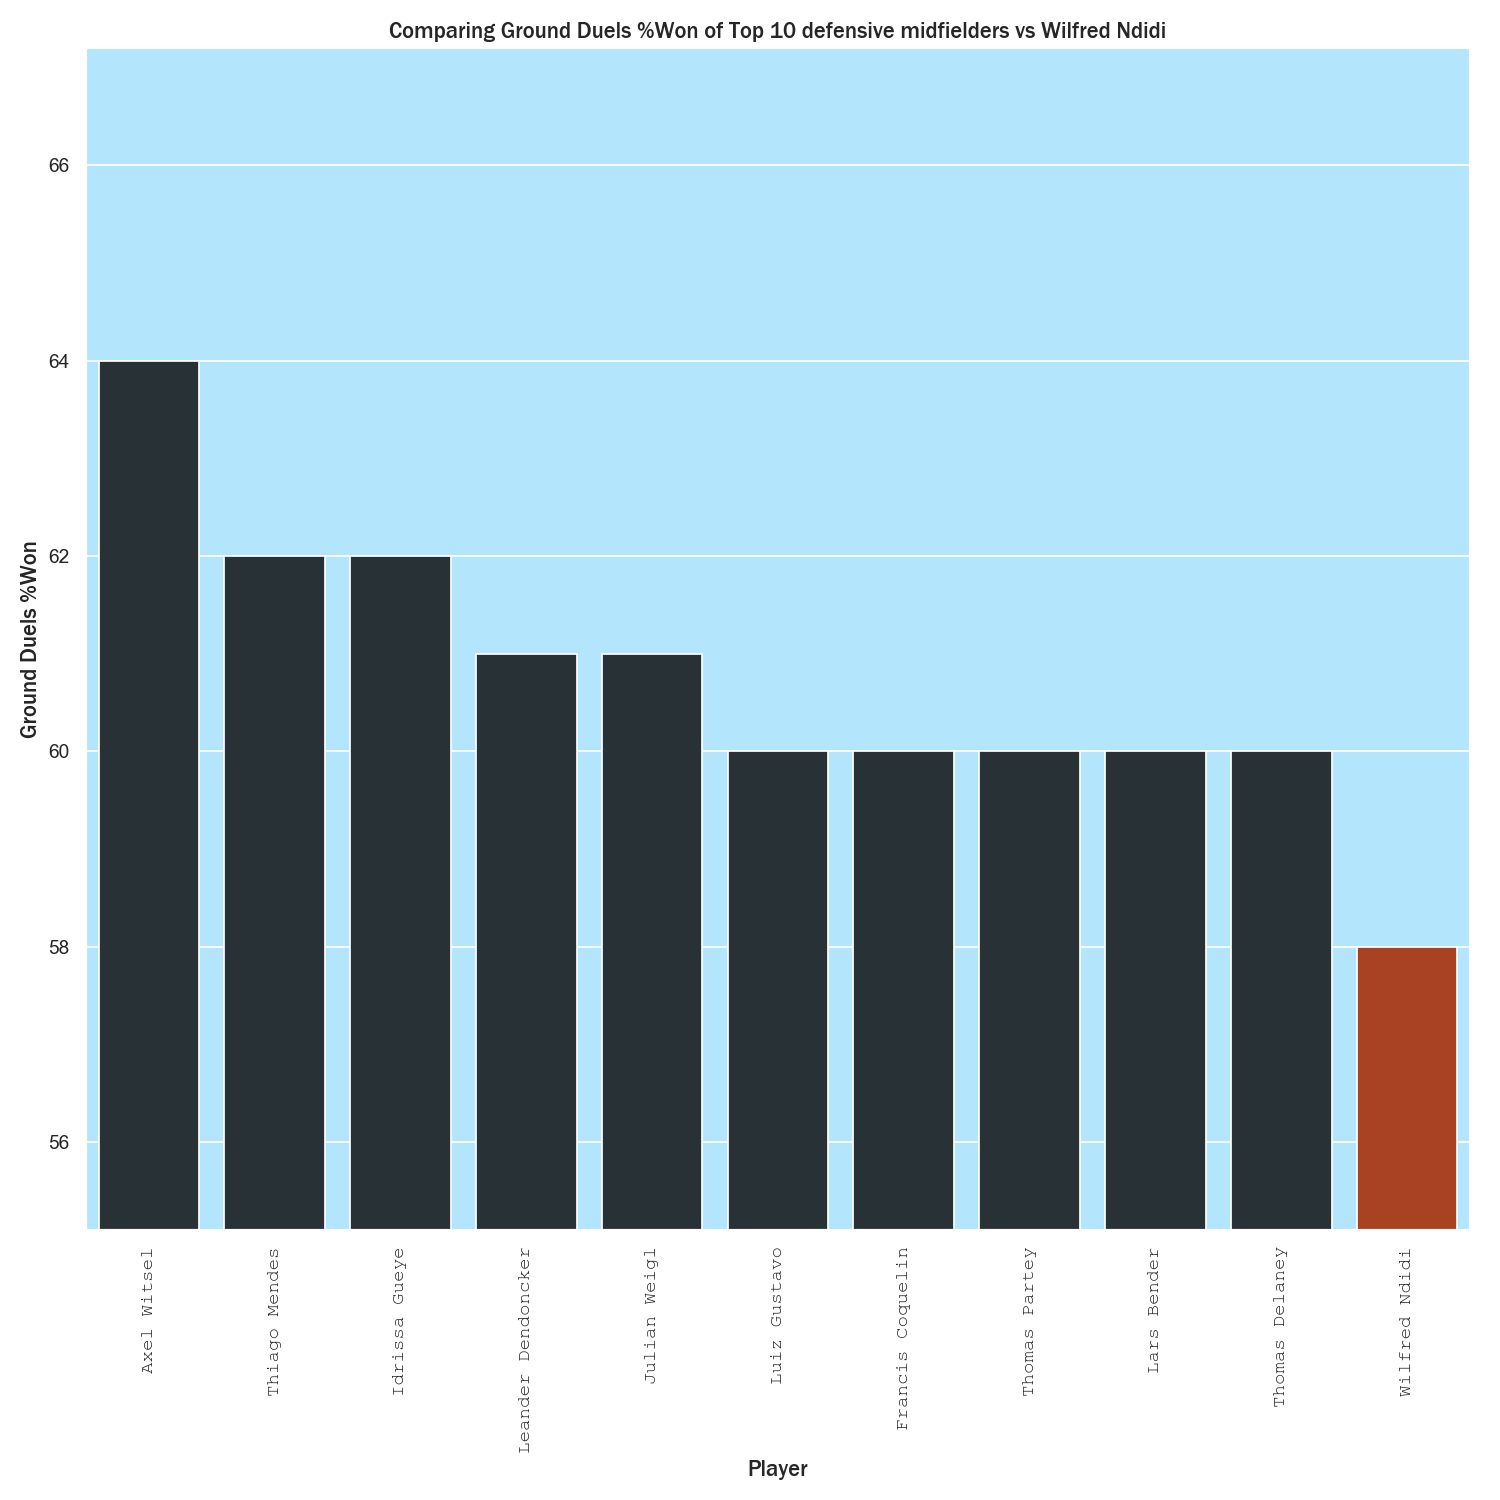

<IPython.core.display.Javascript object>


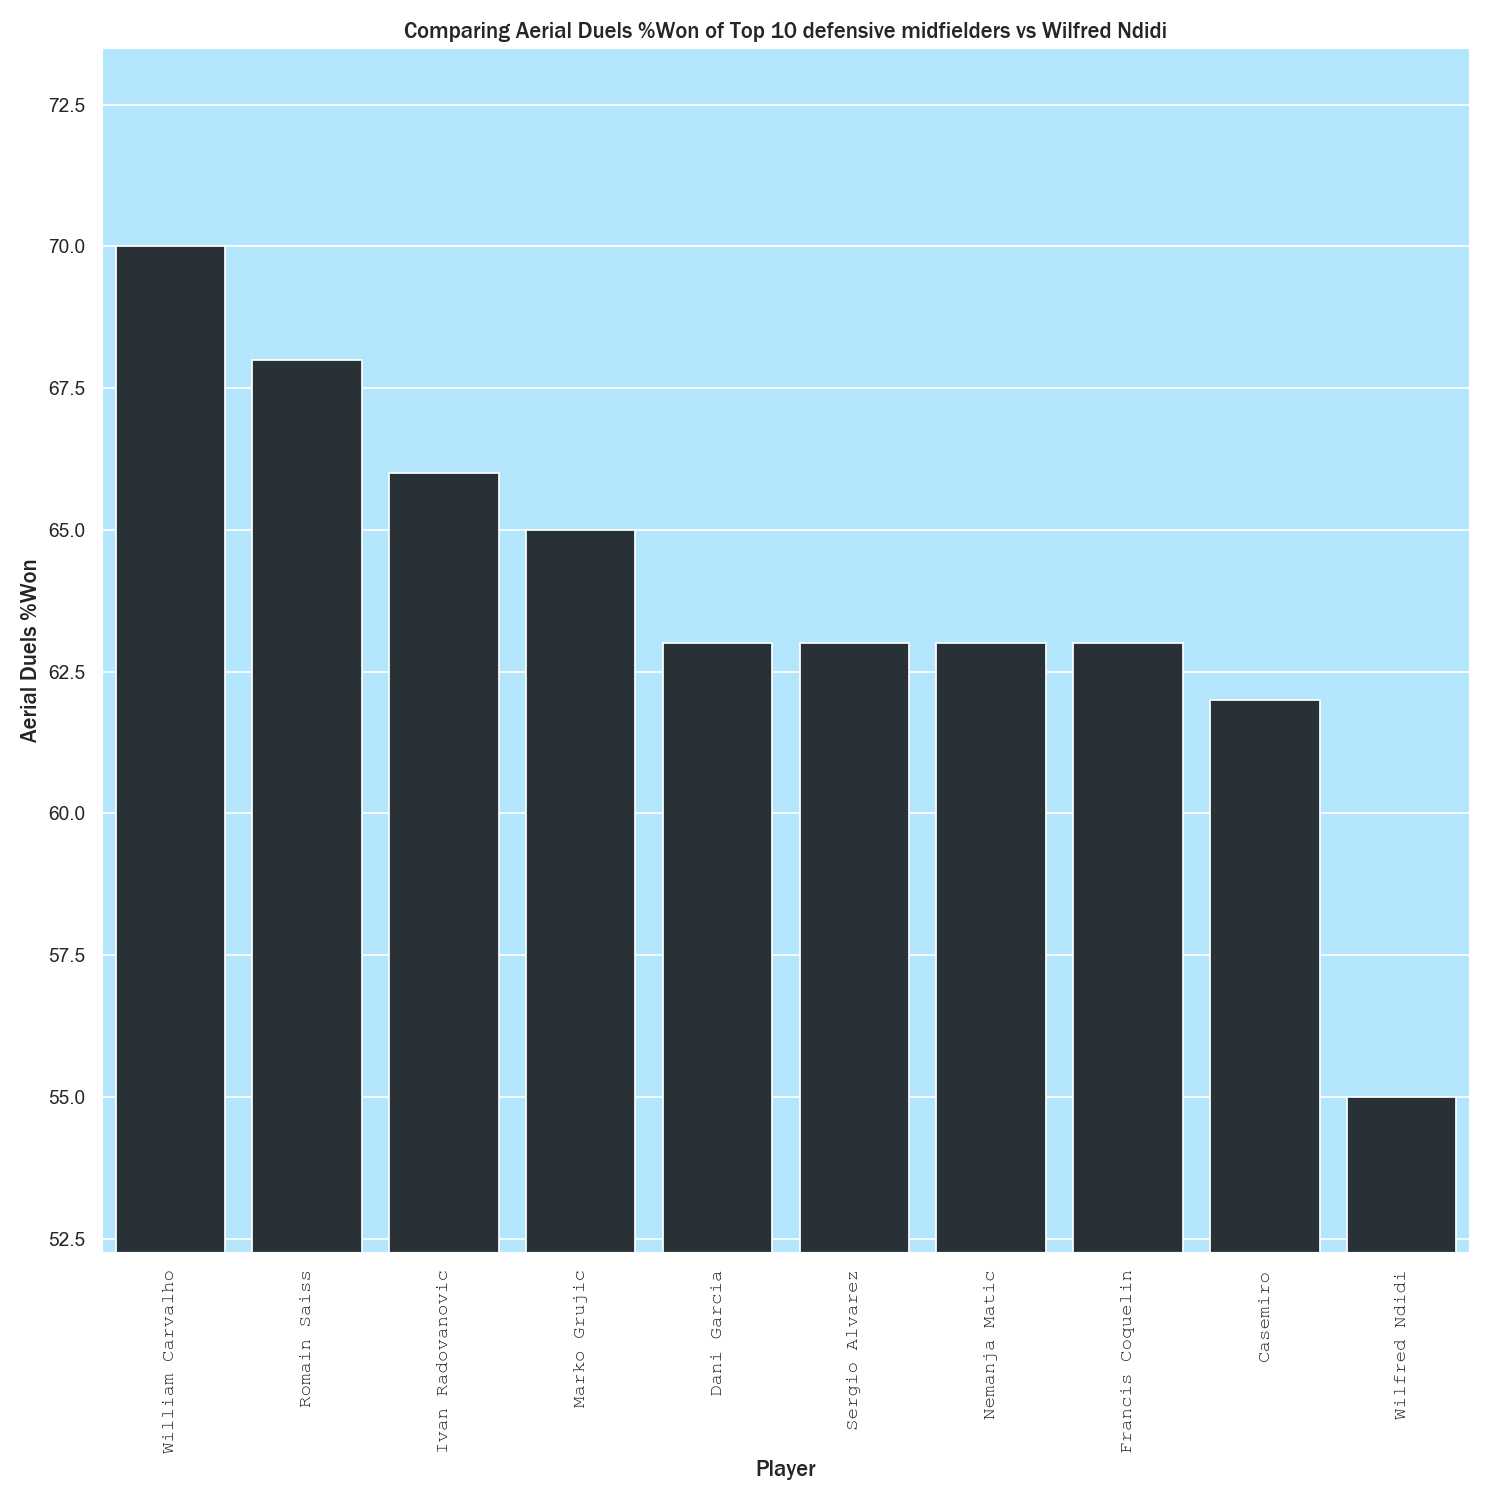

C:\Users\ranja\Anaconda3\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<IPython.core.display.Javascript object>


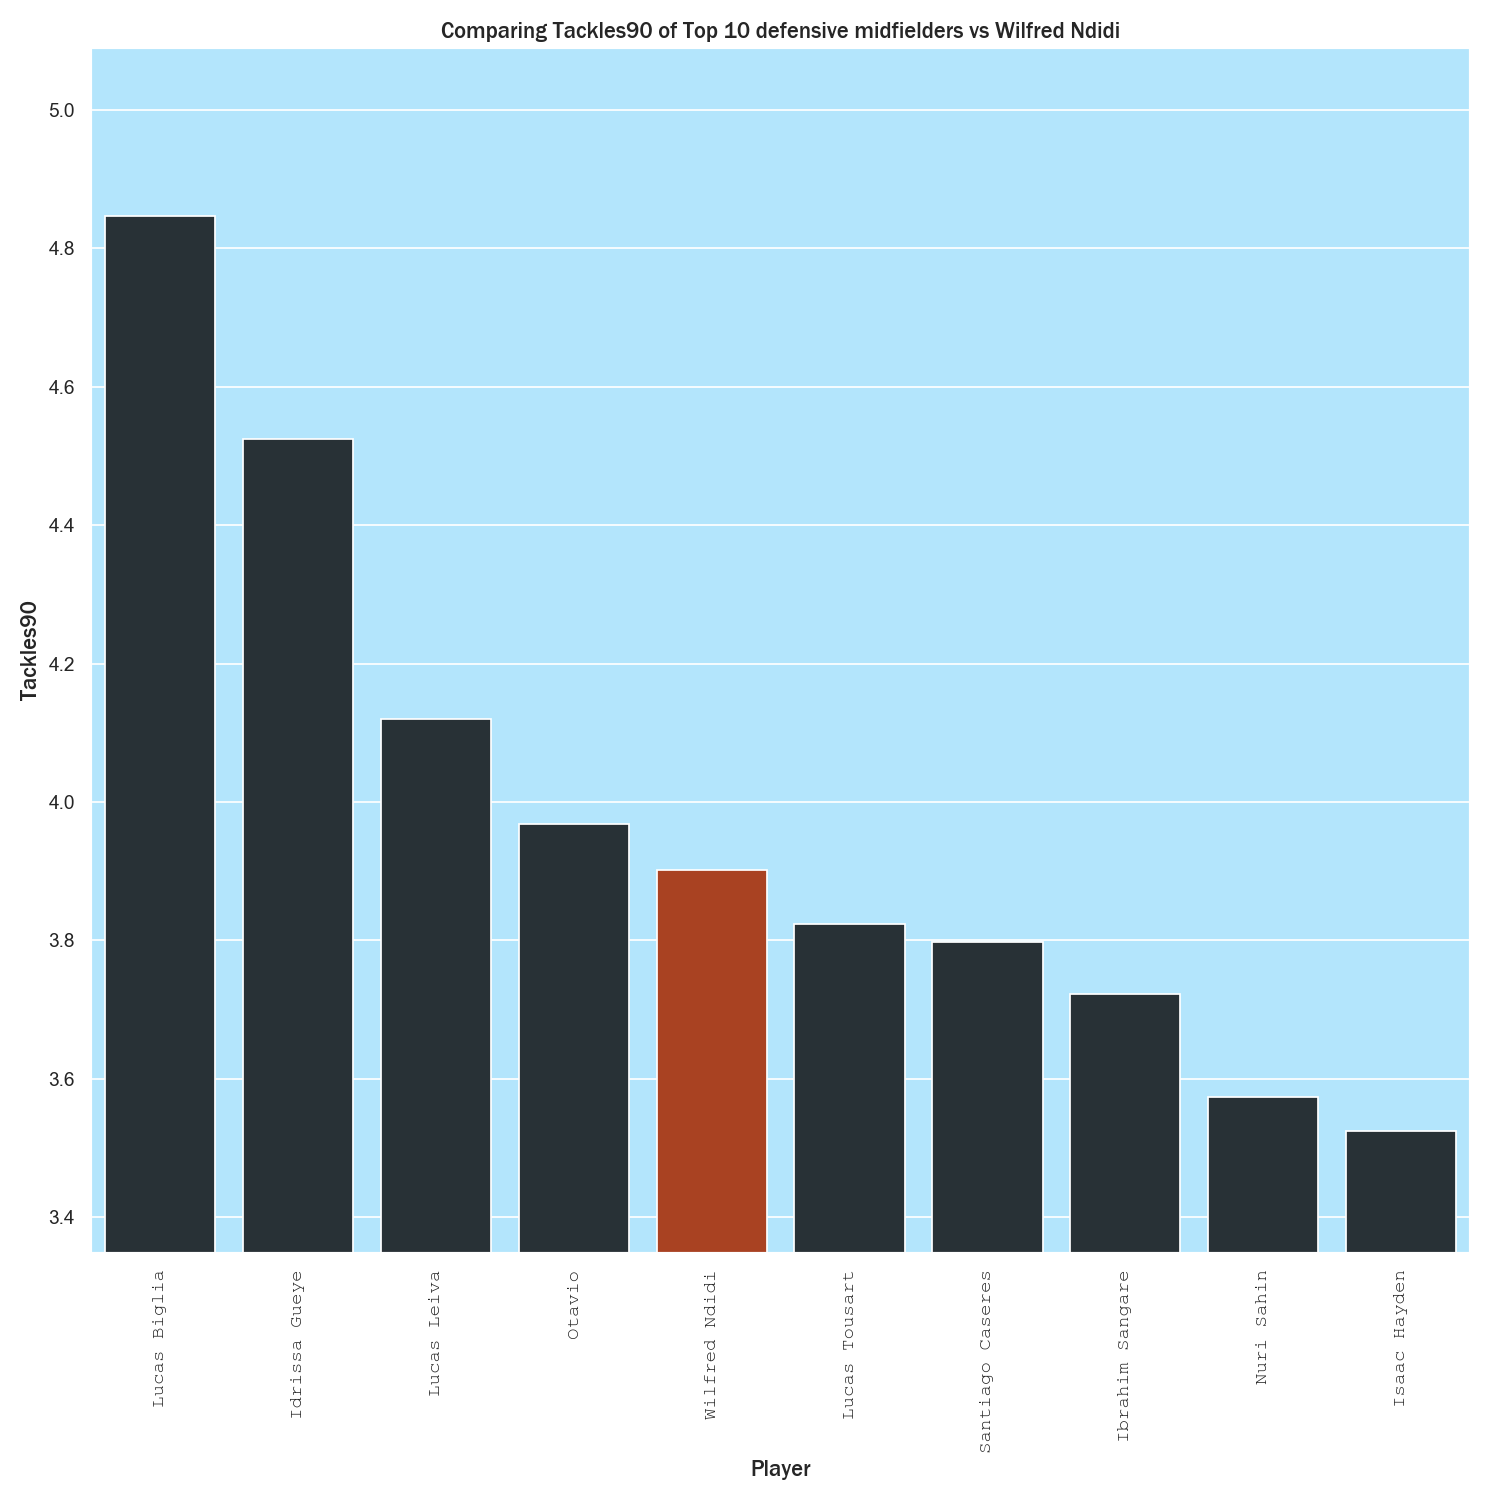

<IPython.core.display.Javascript object>


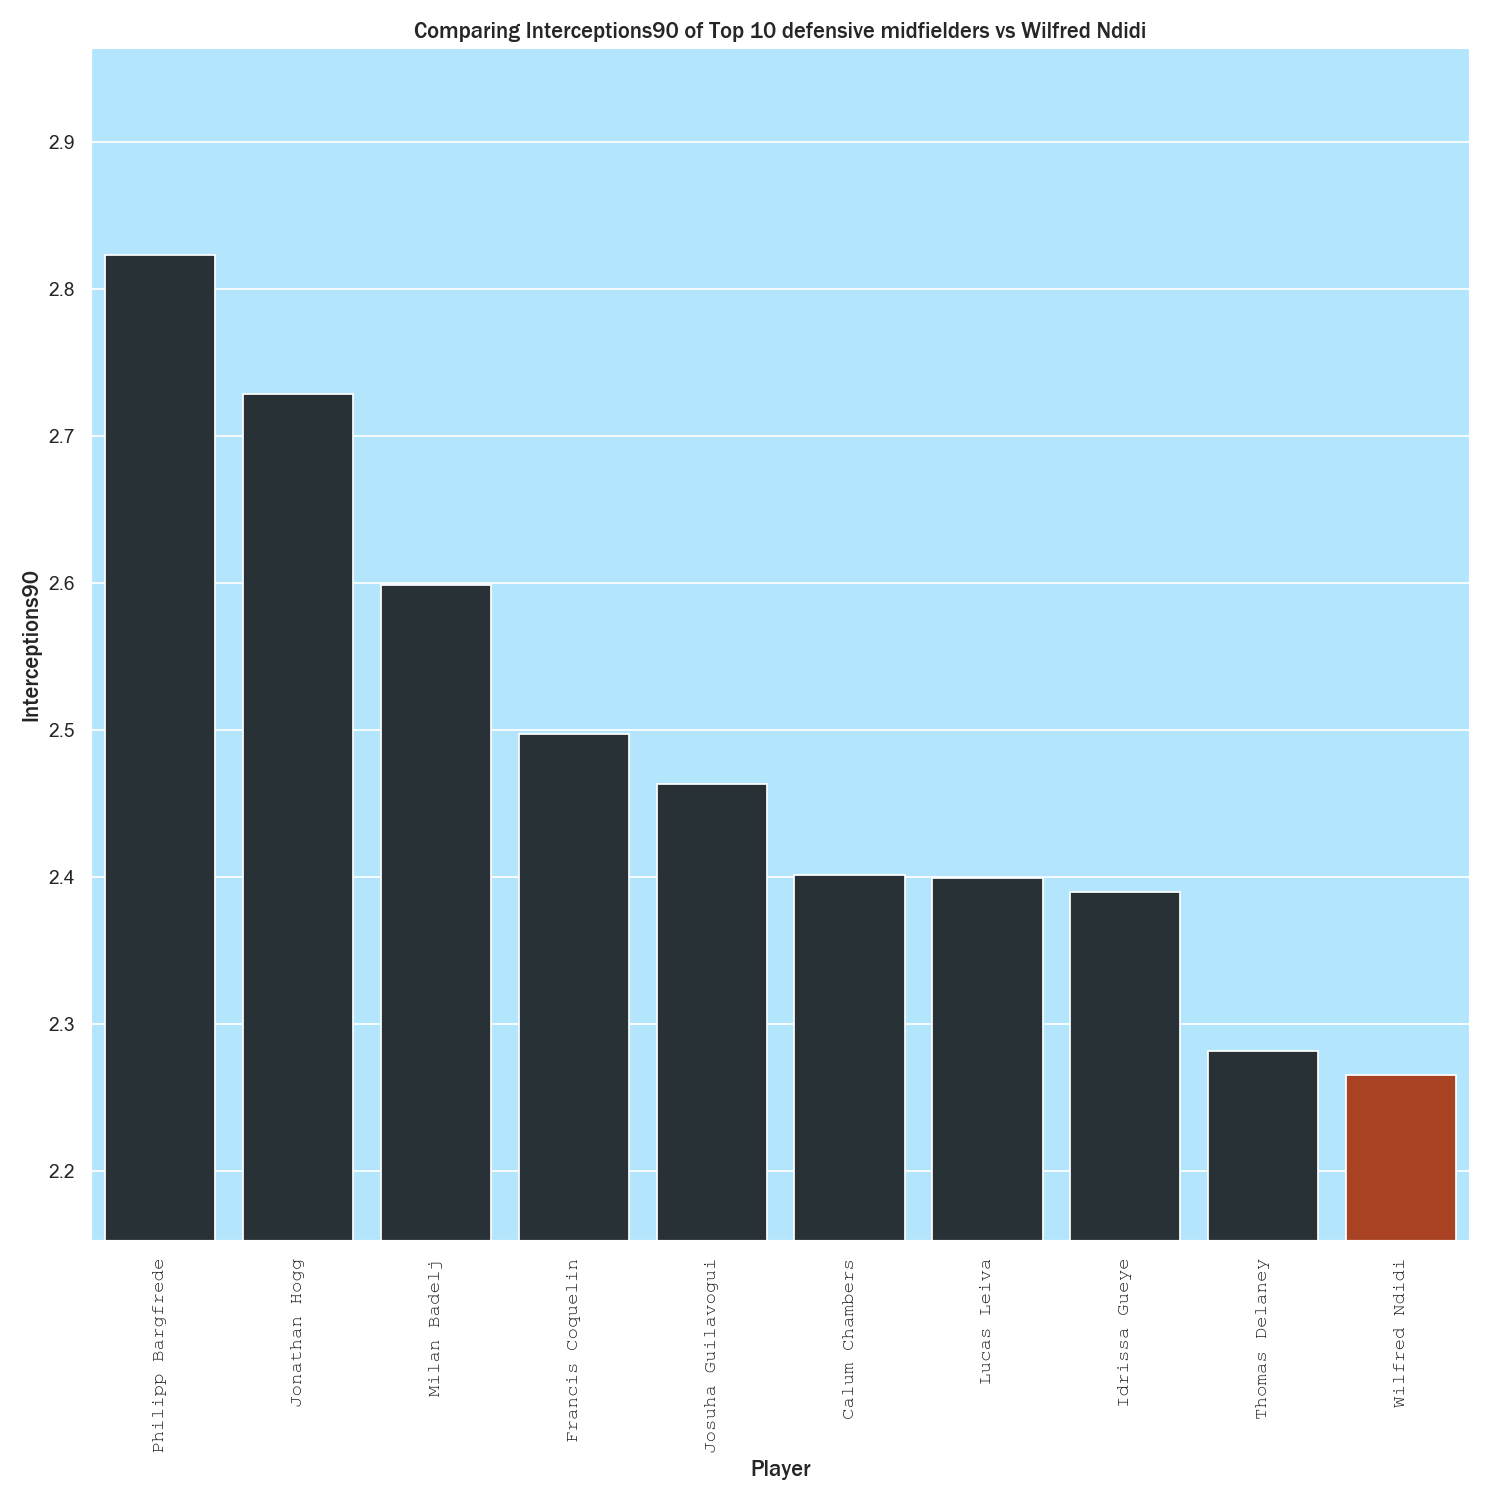

<IPython.core.display.Javascript object>


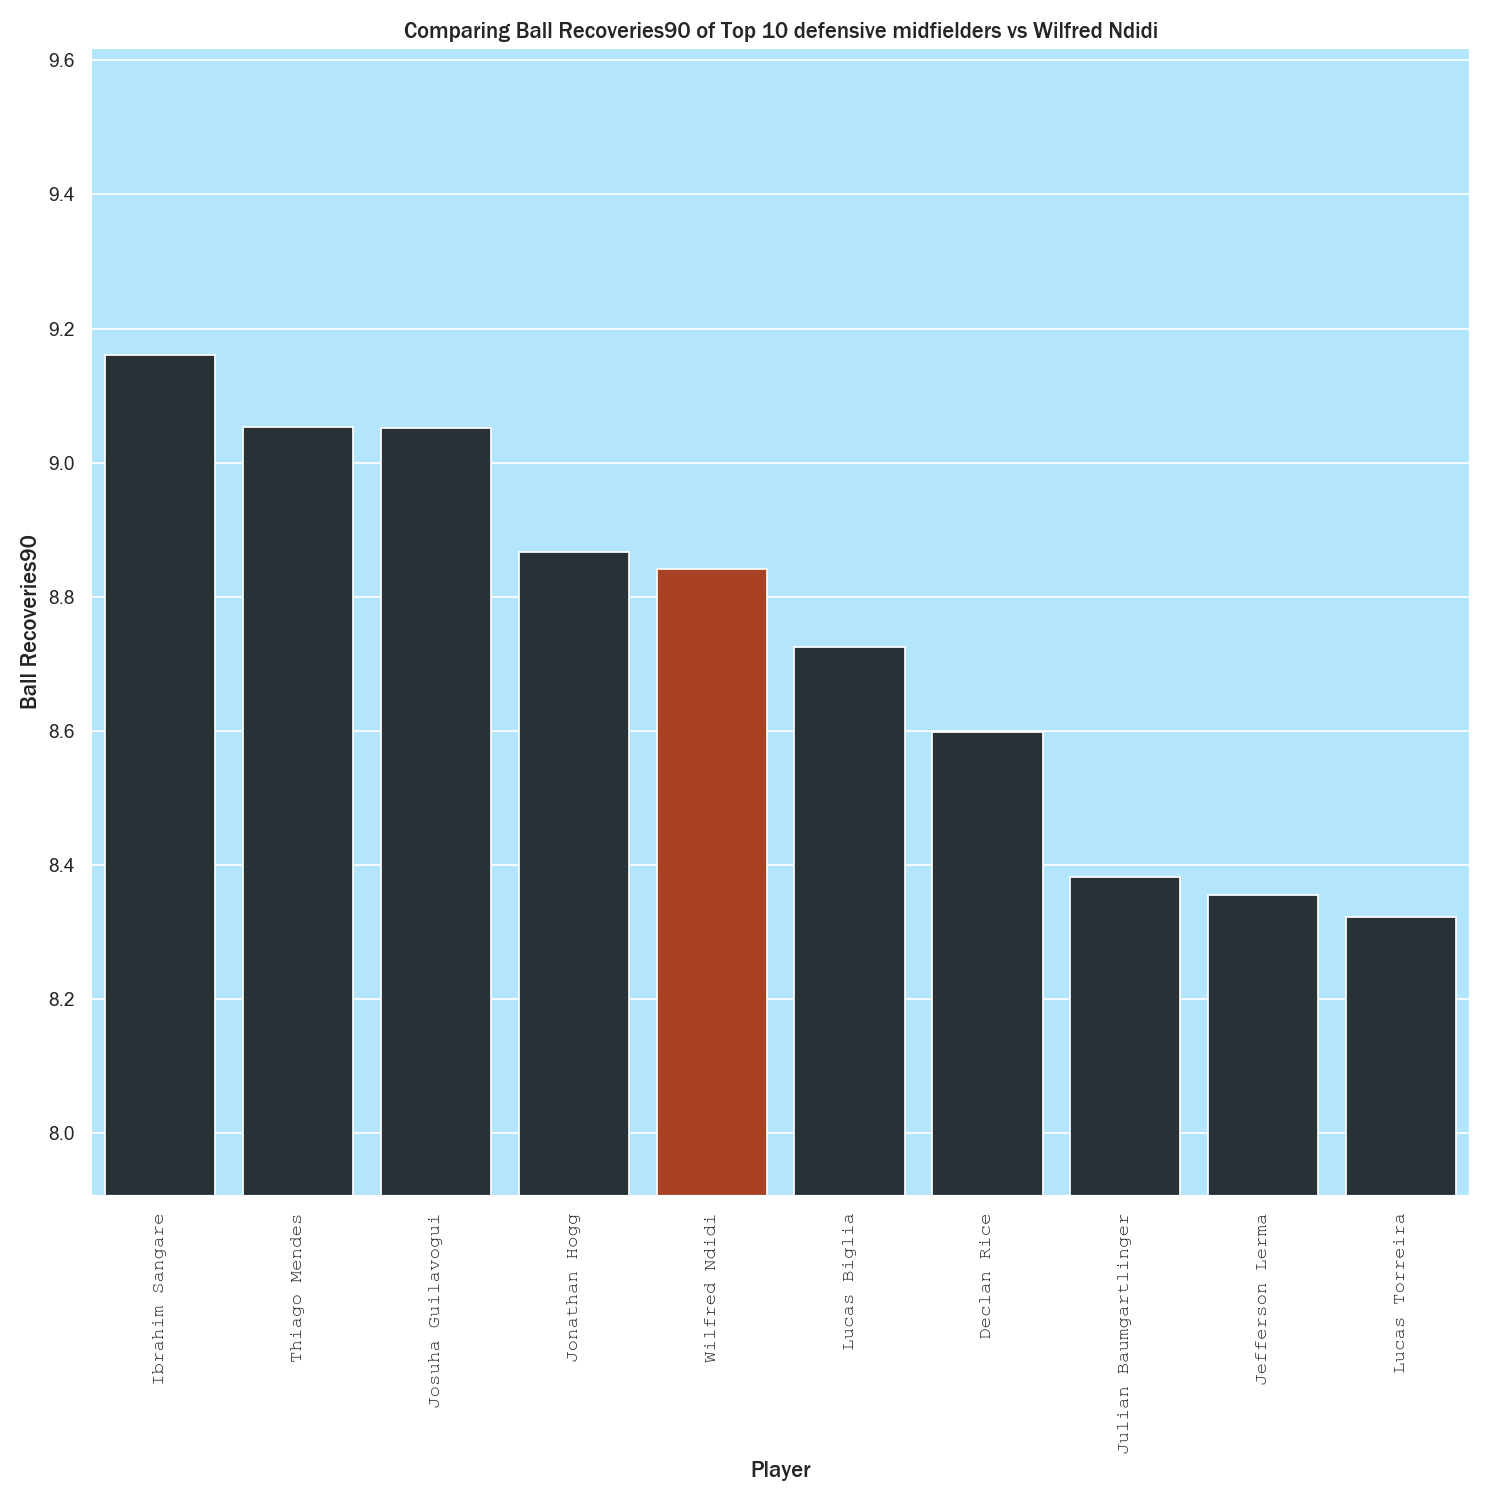

<IPython.core.display.Javascript object>


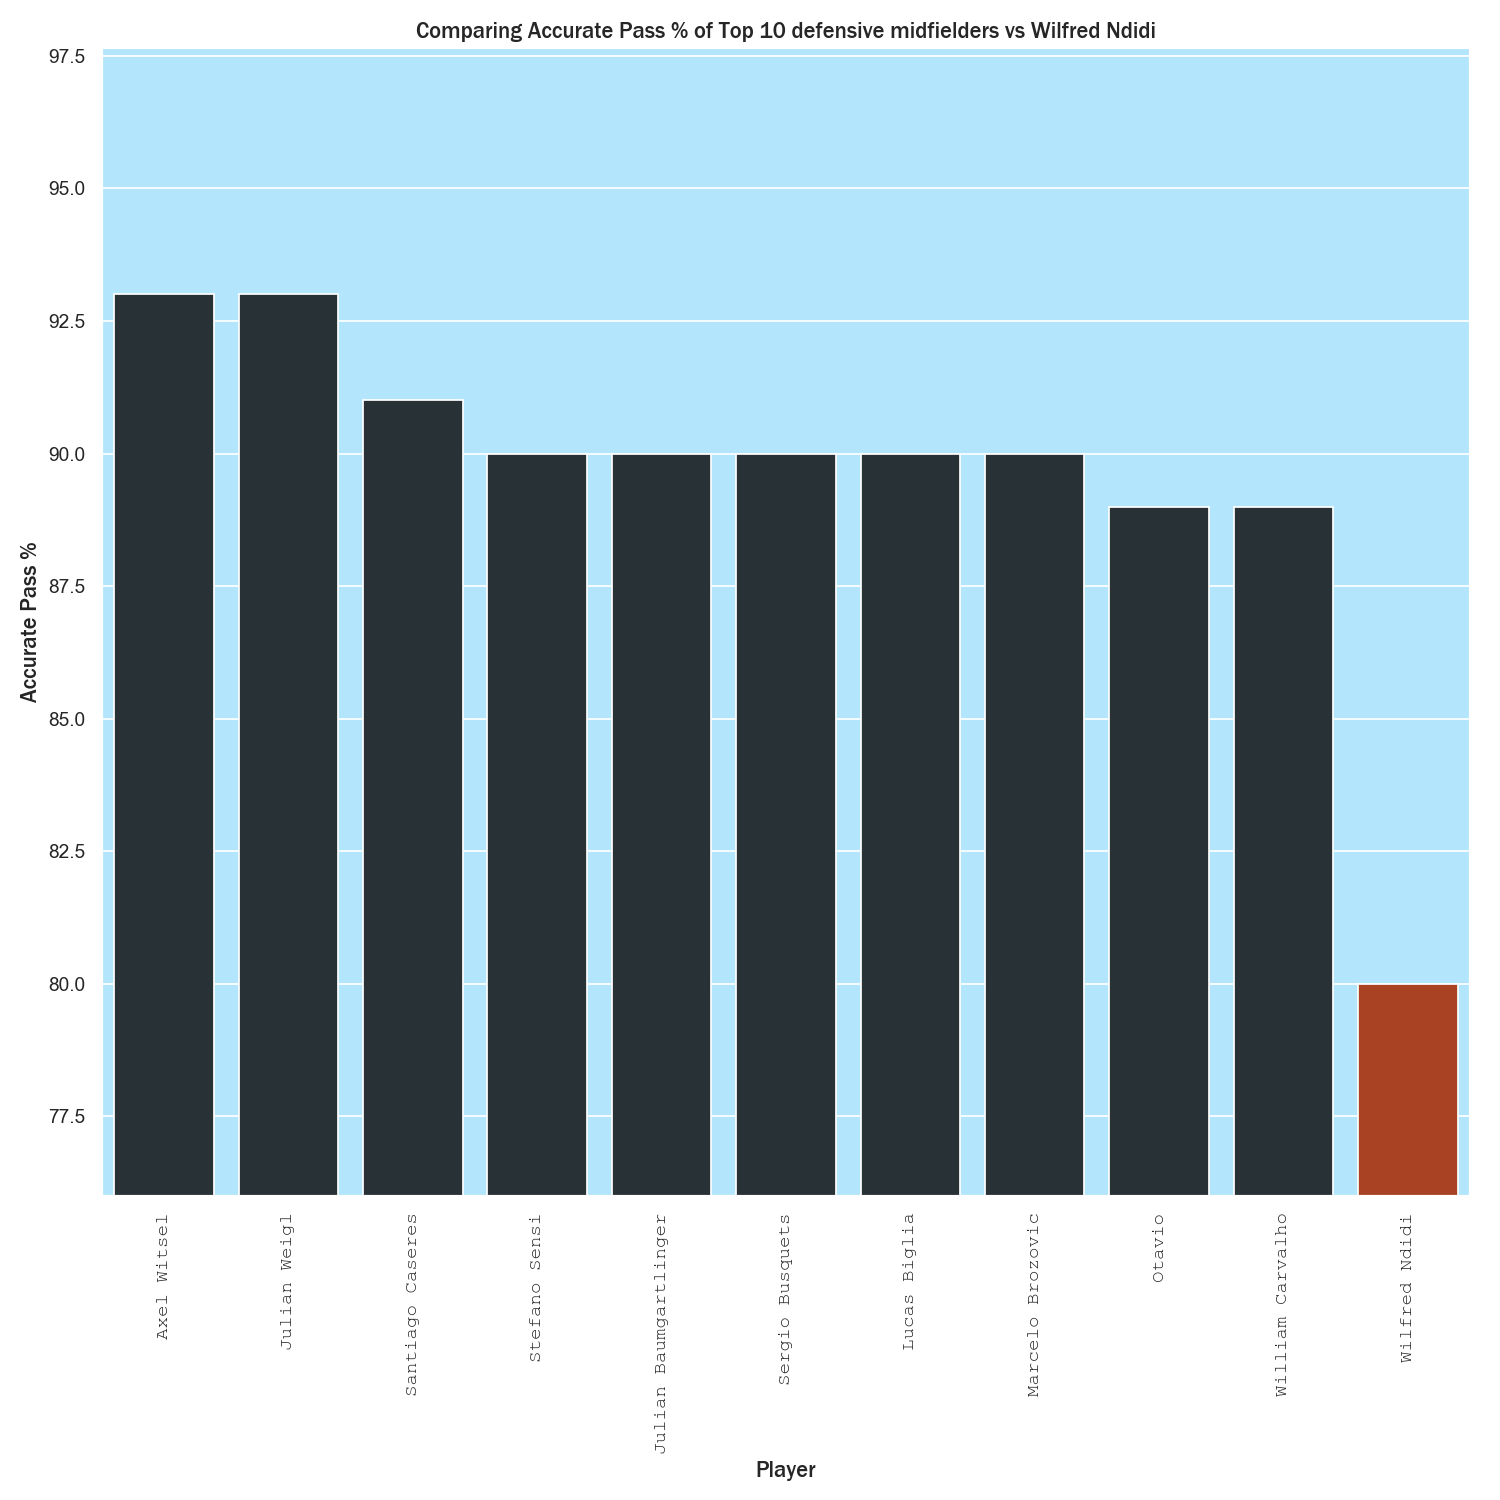

In [477]:
#Plot one-by-one for each statistic

player = ['Thomas Partey', 'Declan Rice', 'Wilfred Ndidi']


for i in DEFENSIVE[0:-4]:
    ax = plot_topn_comparison(i, player[2], cdm_stats, 10, per_90 = False)
    
for i in DEFENSIVE[0:3]:
    ax = plot_topn_comparison(i, player[2], cdm_stats, 10, per_90 = True)
    
plot_topn_comparison('Accurate Pass %', player[2], cdm_stats, 10, per_90 = False)

Content:

Considering that we are supposedly in for Thomas Partey, I decided to visually compare his statistics to few of the best. Here's a brief summary:

1. Partey seems to be average at Intercepting, but slighly below average in the Tackling department
2. His biggest strength seems to be his prowess in Ground Duels. 
3. 84% Accurate pass % is pretty good too.
4. His number of ball recoveries are fairly low, which is a bit of a surprise considering his ability to run around.

Extensive stats for Partey here.

BUT, compared to Wilfred Ndidi who has:
1. Most Tackles made
2. Most Interceptions made
3. Most Ball recoveries
3. 80% Accurate pass %
4. Good ability in Ground Duels.
5. Highest aggregate defensive score (considering tackling, interceptions, blocked shots, aerial and ground duels %won)

Extensive stats for Ndidi here.


Honestly, Ndidi is so good. Defensive stats can be flawed, but considering Leicester are a fairly attack minded team, these stats are really impressive. It could possibly the case that due to the defensive style of Atletico, and the team effort , Partey's statistics may be slightly misleading. Maybe he is worth 50 Million, but on the other hand Ndidi is much better, younger and PL proven. He should be our first choice.

Thoughts?

PS: If you want access to data, you can get it here.
